In [45]:
import numpy as np
from six import raise_from
import csv
import sys
import os
from collections import OrderedDict
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
#Mount google drive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [47]:
def parse(value, function, fmt):
    """
    Parse a string into a value, and format a nice ValueError if it fails.

    Returns `function(value)`.
    Any `ValueError` raised is catched and a new `ValueError` is raised
    with message `fmt.format(e)`, where `e` is the caught `ValueError`.
    """
    try:
        return function(value)
    except ValueError as e:
        raise_from(ValueError(fmt.format(e)), None)

def read_annotations(csv_reader, classes=["0", "1"]):
    """
    Read annotations from the csv_reader.
    Args:
        csv_reader: csv reader of args.annotations_path
        classes: list[str] all the class names read from args.classes_path

    Returns:
        result: dict, dict is like {image_path: [{'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'class': class_name]}

    """
    result = OrderedDict()
    for line, row in enumerate(csv_reader, 1):
        try:
            img_file, x1, y1, x2, y2, class_name = row[:6]
            if img_file not in result:
                result[img_file] = []

            # If a row contains only an image path, it's an image without annotations.
            if (x1, y1, x2, y2, class_name) == ('', '', '', '', ''):
                continue
            x1 = parse(x1, int, 'line {}: malformed x1: {{}}'.format(line))
            y1 = parse(y1, int, 'line {}: malformed y1: {{}}'.format(line))
            x2 = parse(x2, int, 'line {}: malformed x2: {{}}'.format(line))
            y2 = parse(y2, int, 'line {}: malformed y2: {{}}'.format(line))
            
            if class_name not in classes:
                raise ValueError(f'line {line}: unknown class name: \'{class_name}\' (classes: {classes})')

            result[img_file].append({'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'class': class_name})
            
        except ValueError:
            raise_from(ValueError(
                f'line {line}: format should be \'img_file,x1,y1,x2,y2,class_name\' or \'img_file,,,,,\''),
                None)

    return result

def open_for_csv(path):
    """
    Open a file with flags suitable for csv.reader.

    This is different for python2 it means with mode 'rb', for python3 this means 'r' with "universal newlines".
    """
    if sys.version_info[0] < 3:
        return open(path, 'rb')
    else:
        return open(path, 'r', newline='')

In [48]:
chosen_annotations = os.path.abspath("./gdrive/MyDrive/data/annotations/test_annotations.csv")

In [49]:
def visualize_one_sample(image, annotations):
    color = 'red'
    plt.figure(figsize=(6, 4))
    image = np.array(image)
    plt.imshow(image, aspect='equal')
    current_axis = plt.gca()
    
    if len(annotations) == 0:
        print("There is no defects in this image...")
        
    for box in annotations:
        xmin = box["x1"] 
        ymin = box["y1"] 
        xmax = box["x2"] 
        ymax = box["y2"]
        
        w = xmax - xmin
        h = ymax - ymin
        current_axis.add_patch(plt.Rectangle((xmin, ymin), w, h, color=color, fill=False, linewidth=2))

    plt.show()

In [ ]:
image_names = []
image_data = {}

try:
    with open_for_csv(chosen_annotations) as file:
        image_data = read_annotations(csv.reader(file, delimiter=','))
except ValueError as e:
    raise_from(ValueError('invalid CSV annotations file: {}: {}'.format(chosen_annotations, e)), None)
    
image_names = list(image_data.keys())
print("loaded ", len(image_names), " images data")

### plot first 10 images

(256, 256)


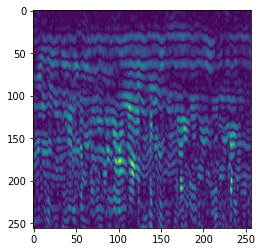

(256, 256)


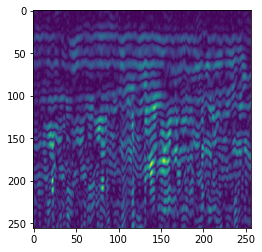

(256, 256)


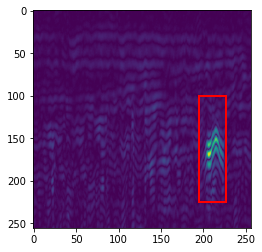

(256, 256)


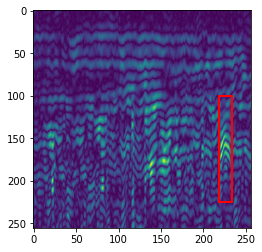

(256, 256)


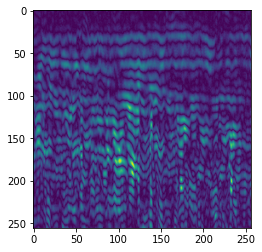

(256, 256)


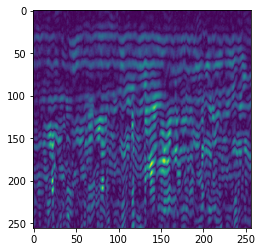

(256, 256)


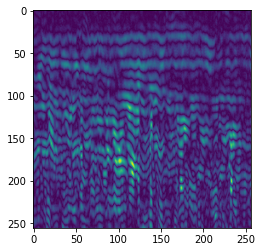

(256, 256)


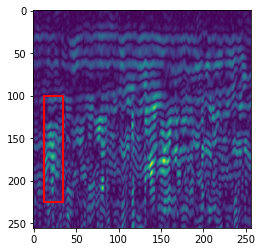

(256, 256)


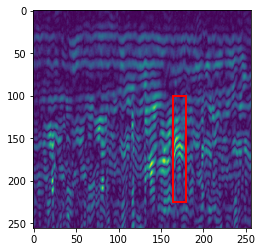

(256, 256)


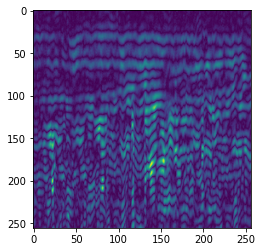

In [51]:
for img_filename in list(image_data)[0:10]:
    full_img_path = os.path.abspath("./gdrive/MyDrive/data/Unzipped images/images/" + img_filename)
    image = cv2.cvtColor(cv2.imread(full_img_path), cv2.COLOR_BGR2GRAY)
    print(image.shape)
    visualize_one_sample(image,image_data[img_filename])